In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from pathlib import Path
import os
import sys

import joblib
import json
import pickle

import warnings
warnings.filterwarnings('ignore')

### 1. Load Data 

In [2]:
file_path = 'C:\\Users\\NikoWang\\OneDrive - endurancedirect.com\\Documents\\Actuarial Work\\ML Project\\Data.csv'
df = pd.read_csv(file_path, delimiter=",")

In [3]:
# Show the first 10 rows of the dataframe
df.head(10)

,Contract_Number,Sale_Date,Cancel_Date,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status,Duration
0,83524003419,2012-02-20,NaN,0.0,18.0,BMW,525,44371,N,92371,12,48000.0,3746.0,250.0,0.00,2078.0,NaN,NaN,Not_Cancelled,0.0
1,83524005048,2012-05-10,NaN,0.0,16.0,GMC,SIERRA,29877,N,89877,12,60000.0,2993.0,195.0,0.00,909.0,NaN,NaN,Not_Cancelled,0.0
2,SAH010581,2016-12-30,NaN,0.0,17.0,BMW,X3,83211,U,143211,12,60000.0,3895.0,205.0,0.00,1565.0,NaN,NaN,Not_Cancelled,0.0
3,179001410,2012-06-01,2012-06-05,48.0,22.0,MERZ,MESL5,40980,N,140980,18,100000.0,5875.0,1500.0,0.00,3465.0,NaN,NaN,Cancelled,0.0
4,83524018310,2015-07-16,2016-02-15,48.0,17.0,HYUN,HYACC,166559,U,241559,18,75000.0,3325.0,175.0,175.00,1213.0,NaN,NaN,Cancelled,7.0
5,2007615DAS,2012-03-21,2012-08-21,60.0,20.0,KIA,KISOR,155256,U,255256,18,100000.0,2881.0,200.0,148.94,1031.0,NaN,NaN,Cancelled,5.0
6,1007222DAS,2012-02-28,2012-04-26,60.0,22.0,CHEV,CHTAH,170125,U,270125,18,100000.0,2931.0,150.0,154.50,1031.0,NaN,NaN,Cancelled,2.0
7,AAF767708,2011-05-12,2011-07-15,60.0,26.0,LINC,LNNAV,139131,U,199131,18,60000.0,3192.0,186.0,0.00,1443.0,NaN,NaN,Cancelled,2.0
8,1005199DAS,2011-05-14,2012-02-13,60.0,27.0,CHEV,CHS10,155063,U,255063,24,100000.0,2704.0,225.0,103.29,757.0,NaN,NaN,Cancelled,9.0
9,1005078DAS,2011-04-08,2011-07-19,60.0,27.0,JEEP,JPWRN,149978,U,249978,18,100000.0,2800.0,560.0,124.44,824.0,NaN,NaN,Cancelled,3.0


In [4]:
df['Status'].unique()
df.shape

(2055830, 20)

### 2. Data Cleaning and Preprocessing
- Add a new column 'Duration_Norm' 
- Filter out 'Cancelled' and 'Not_Cancelled' contracts 
- Drop missing values 

In [5]:
# Normalize the 'Duration' column by dividing it by the 'Term' column
df['Duration_Norm'] = df['Duration']/df['Term']

In [6]:
# Training set: Cancelled and Not_Cancelled
df_model = df[df['Status'].isin(['Cancelled', 'Not_Cancelled'])]

# Holdout/Other set: Active
df_active = df[df['Status'] == 'Active']

df_model.shape

(1538268, 21)

In [7]:
# Exclude rows where 'Duration' or 'Term' is NaN

df_model= df_model[df_model['Duration_Norm'].notna()]
df_model.head()

,Contract_Number,Sale_Date,Cancel_Date,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,...,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status,Duration,Duration_Norm
3,179001410,2012-06-01,2012-06-05,48.0,22.0,MERZ,MESL5,40980,N,140980,...,100000.0,5875.0,1500.0,0.00,3465.0,NaN,NaN,Cancelled,0.0,0.000000
4,83524018310,2015-07-16,2016-02-15,48.0,17.0,HYUN,HYACC,166559,U,241559,...,75000.0,3325.0,175.0,175.00,1213.0,NaN,NaN,Cancelled,7.0,0.145833
5,2007615DAS,2012-03-21,2012-08-21,60.0,20.0,KIA,KISOR,155256,U,255256,...,100000.0,2881.0,200.0,148.94,1031.0,NaN,NaN,Cancelled,5.0,0.083333
6,1007222DAS,2012-02-28,2012-04-26,60.0,22.0,CHEV,CHTAH,170125,U,270125,...,100000.0,2931.0,150.0,154.50,1031.0,NaN,NaN,Cancelled,2.0,0.033333
7,AAF767708,2011-05-12,2011-07-15,60.0,26.0,LINC,LNNAV,139131,U,199131,...,60000.0,3192.0,186.0,0.00,1443.0,NaN,NaN,Cancelled,2.0,0.033333


In [8]:
# Fill with 'Unknown' for missing categorical variables
#df_model['Make'] = df_model['Make'].fillna('Unknown')
#df_model['Model'] = df_model['Model'].fillna('Unknown')
df_model.drop(columns=['Contract_Number','Sale_Date','Cancel_Date'], inplace=True)


In [9]:
df_model['Vehicle_Age'] = df_model['Vehicle_Age'].fillna(df_model['Vehicle_Age'].median())
# df_model['Down_Payment'] = df_model['Down_Payment'].fillna(0)
# df_model['Paid_In_Full'] = df_model['Paid_In_Full'].fillna(0)
# df_model['Customer_Monthly_Payment'] = df_model['Customer_Monthly_Payment'].fillna(0)
df_model = df_model.dropna(subset=[
    'Down_Payment',
    'Paid_In_Full',
    'Customer_Monthly_Payment',
    'Make',
    'Model',
    'New_Used'
])

print(df_model.isna().sum())  # check if any missing values remain
print("Shape after drop:", df_model.shape)


Term                        0
Vehicle_Age                 0
Make                        0
Model                       0
Mileage                     0
New_Used                    0
Expiration_Miles            0
Finance_Term                0
Policy_Miles                0
Customer_Cost               0
Down_Payment                0
Finance_Payment             0
Warranty_Cost               0
Paid_In_Full                0
Customer_Monthly_Payment    0
Status                      0
Duration                    0
Duration_Norm               0
dtype: int64
Shape after drop: (1304208, 18)


In [10]:
# Show the first 10 rows of the dataframe
df_model.head(10)

,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status,Duration,Duration_Norm
97127,60.0,11.0,MERCEDES-BENZ,C,62612,USED,163612,36,100000.0,3129.0,189.00,81.67,1629.0,0.0,79.90,Cancelled,15.0,0.250000
97128,72.0,19.0,FORD,F350,124000,USED,200000,36,75000.0,3594.0,179.70,94.84,1694.0,0.0,94.84,Cancelled,3.0,0.041667
97129,60.0,14.0,CHEVROLET,SILVERADO,99691,USED,175691,36,75000.0,3388.0,169.40,89.41,1088.0,0.0,89.41,Not_Cancelled,60.0,1.000000
97130,60.0,14.0,CHEVROLET,CAMARO,41006,USED,96006,36,54000.0,3780.0,189.00,99.75,1348.0,0.0,99.75,Cancelled,30.0,0.500000
97133,60.0,10.0,NISSAN,ROGUE,66926,USED,167926,36,100000.0,3501.0,175.05,92.39,1001.0,0.0,92.39,Cancelled,0.0,0.000000
97134,60.0,12.0,DODGE,DURANGO,97102,USED,198102,36,100000.0,3955.0,197.95,104.36,2073.0,0.0,104.36,Not_Cancelled,60.0,1.000000
97135,60.0,14.0,JEEP,LIBERTY,92001,USED,153001,36,60000.0,3517.0,175.85,92.81,1835.0,0.0,92.81,Cancelled,3.0,0.050000
97136,60.0,11.0,CADILLAC,ATS,95646,USED,146646,36,50000.0,3607.0,180.35,95.18,1207.0,0.0,95.18,Cancelled,11.0,0.183333
97138,60.0,11.0,CADILLAC,ATS,24631,NEW,61000,36,60000.0,2754.0,137.70,72.68,1322.0,0.0,72.68,Cancelled,9.0,0.150000
97139,60.0,9.0,CHEVROLET,SILVERADO,86766,USED,212766,36,125000.0,4305.0,116.35,116.35,2123.0,0.0,113.60,Not_Cancelled,60.0,1.000000


In [11]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1304208 entries, 97127 to 2055829
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Term                      1304208 non-null  float64
 1   Vehicle_Age               1304208 non-null  float64
 2   Make                      1304208 non-null  object 
 3   Model                     1304208 non-null  object 
 4   Mileage                   1304208 non-null  int64  
 5   New_Used                  1304208 non-null  object 
 6   Expiration_Miles          1304208 non-null  int64  
 7   Finance_Term              1304208 non-null  int64  
 8   Policy_Miles              1304208 non-null  float64
 9   Customer_Cost             1304208 non-null  float64
 10  Down_Payment              1304208 non-null  float64
 11  Finance_Payment           1304208 non-null  float64
 12  Warranty_Cost             1304208 non-null  float64
 13  Paid_In_Full              13

### Encoding categorical variables

In [12]:
# If your column name is 'Status'
df_model['Status_bin'] = df_model['Status'].map({
    'Cancelled':      1,     # or 0—choose whichever makes sense
    'Not_Cancelled':  0
}).astype('int8')            # keeps the column small

# (Optional) drop the original text column
df_model.drop(columns=['Status'], inplace=True)



In [13]:
cat_cols = df_model.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_cols)


Categorical columns: ['Make', 'Model', 'New_Used']


In [14]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

label_encoders = {}
for column in cat_cols:
    le = LabelEncoder()
    df_model[column] = le.fit_transform(df_model[column])
    label_encoders[column] = le


In [15]:
df_model.head(10)

,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Duration,Duration_Norm,Status_bin
97127,60.0,11.0,44,261,62612,5,163612,36,100000.0,3129.0,189.00,81.67,1629.0,0.0,79.90,15.0,0.250000,1
97128,72.0,19.0,18,572,124000,5,200000,36,75000.0,3594.0,179.70,94.84,1694.0,0.0,94.84,3.0,0.041667,1
97129,60.0,14.0,12,1301,99691,5,175691,36,75000.0,3388.0,169.40,89.41,1088.0,0.0,89.41,60.0,1.000000,0
97130,60.0,14.0,12,290,41006,5,96006,36,54000.0,3780.0,189.00,99.75,1348.0,0.0,99.75,30.0,0.500000,1
97133,60.0,10.0,52,1189,66926,5,167926,36,100000.0,3501.0,175.05,92.39,1001.0,0.0,92.39,0.0,0.000000,1
97134,60.0,12.0,16,470,97102,5,198102,36,100000.0,3955.0,197.95,104.36,2073.0,0.0,104.36,60.0,1.000000,0
97135,60.0,14.0,33,850,92001,5,153001,36,60000.0,3517.0,175.85,92.81,1835.0,0.0,92.81,3.0,0.050000,1
97136,60.0,11.0,10,201,95646,5,146646,36,50000.0,3607.0,180.35,95.18,1207.0,0.0,95.18,11.0,0.183333,1
97138,60.0,11.0,10,201,24631,1,61000,36,60000.0,2754.0,137.70,72.68,1322.0,0.0,72.68,9.0,0.150000,1
97139,60.0,9.0,12,1301,86766,5,212766,36,125000.0,4305.0,116.35,116.35,2123.0,0.0,113.60,60.0,1.000000,0


In [16]:
# Drop unnecessary columns for modeling
X = df_model.drop(columns=['Duration', 'Duration_Norm'])

# Define the target variable
y = df_model['Duration_Norm']


In [17]:
X.head(10)

,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status_bin
97127,60.0,11.0,44,261,62612,5,163612,36,100000.0,3129.0,189.00,81.67,1629.0,0.0,79.90,1
97128,72.0,19.0,18,572,124000,5,200000,36,75000.0,3594.0,179.70,94.84,1694.0,0.0,94.84,1
97129,60.0,14.0,12,1301,99691,5,175691,36,75000.0,3388.0,169.40,89.41,1088.0,0.0,89.41,0
97130,60.0,14.0,12,290,41006,5,96006,36,54000.0,3780.0,189.00,99.75,1348.0,0.0,99.75,1
97133,60.0,10.0,52,1189,66926,5,167926,36,100000.0,3501.0,175.05,92.39,1001.0,0.0,92.39,1
97134,60.0,12.0,16,470,97102,5,198102,36,100000.0,3955.0,197.95,104.36,2073.0,0.0,104.36,0
97135,60.0,14.0,33,850,92001,5,153001,36,60000.0,3517.0,175.85,92.81,1835.0,0.0,92.81,1
97136,60.0,11.0,10,201,95646,5,146646,36,50000.0,3607.0,180.35,95.18,1207.0,0.0,95.18,1
97138,60.0,11.0,10,201,24631,1,61000,36,60000.0,2754.0,137.70,72.68,1322.0,0.0,72.68,1
97139,60.0,9.0,12,1301,86766,5,212766,36,125000.0,4305.0,116.35,116.35,2123.0,0.0,113.60,0


In [18]:
y.head(10)

97127    0.250000
97128    0.041667
97129    1.000000
97130    0.500000
97133    0.000000
97134    1.000000
97135    0.050000
97136    0.183333
97138    0.150000
97139    1.000000
Name: Duration_Norm, dtype: float64

In [19]:
from sklearn.model_selection import train_test_split

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
from sklearn.decomposition import PCA

In [22]:
X_scaled = scaler.fit_transform(X)

In [23]:
# Apply PCA
pca = PCA(n_components=12)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

In [24]:
print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 1043366
Testing set size: 260842


In [25]:
print(X_train.dtypes)


Term                        float64
Vehicle_Age                 float64
Make                          int32
Model                         int32
Mileage                       int64
New_Used                      int32
Expiration_Miles              int64
Finance_Term                  int64
Policy_Miles                float64
Customer_Cost               float64
Down_Payment                float64
Finance_Payment             float64
Warranty_Cost               float64
Paid_In_Full                float64
Customer_Monthly_Payment    float64
Status_bin                     int8
dtype: object


In [26]:
# Convert all columns in X_train to numeric, raising an error if conversion fails
X_train_numeric = X_train.apply(pd.to_numeric, errors='raise')

y_train_clean = y_train.astype(float)

In [27]:

# Check Columns that are NOT numeric 
bad_cols = X_train_numeric.select_dtypes(exclude=[np.number]).columns
print("Still non-numeric:", bad_cols.tolist())


Still non-numeric: []


### 3. Model Training - Generalized Linear Model (GLM)

In [28]:
import statsmodels.api as sm

# Add intercept (constant) term
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm  = sm.add_constant(X_test_scaled)

# Fit GLM
glm_model = sm.GLM(y_train, X_train_sm, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Summary
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          Duration_Norm   No. Observations:              1043366
Model:                            GLM   Df Residuals:                  1043349
Model Family:                Gaussian   Df Model:                           16
Link Function:               Identity   Scale:                        0.025390
Method:                          IRLS   Log-Likelihood:             4.3588e+05
Date:                Fri, 20 Jun 2025   Deviance:                       26491.
Time:                        11:52:32   Pearson chi2:                 2.65e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8764
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1915      0.000   1227.571      0.0

In [29]:
# Predict
y_pred = glm_results.predict(X_test_sm)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")



R²: 0.6761
RMSE: 0.1599


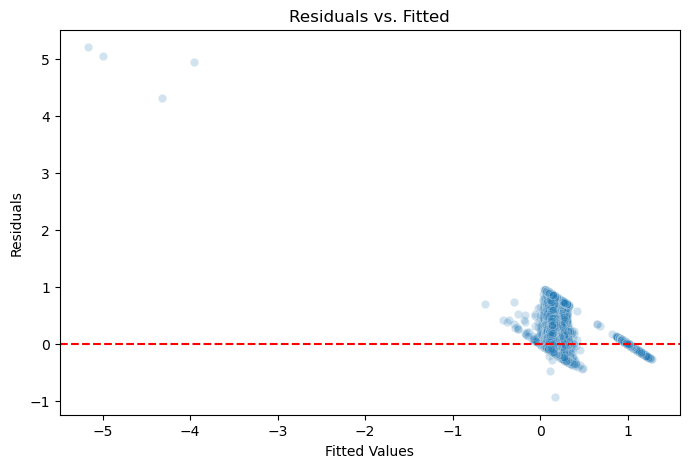

In [30]:
# Plot residuals vs. fitted values

import matplotlib.pyplot as plt
import seaborn as sns

fitted_vals = glm_results.fittedvalues
residuals = y_train - fitted_vals

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.show()


### Try a Gamma GLM with Log Link Function
- Target Duration_Norm is positive and right-skewed

- The residual plot shows non-normality + possible heteroscedasticity

### CatBoost 


In [43]:
df.head()

,Contract_Number,Sale_Date,Cancel_Date,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,...,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status,Duration,Duration_Norm
0,83524003419,2012-02-20,NaN,0.0,18.0,BMW,525,44371,N,92371,...,48000.0,3746.0,250.0,0.0,2078.0,NaN,NaN,Not_Cancelled,0.0,NaN
1,83524005048,2012-05-10,NaN,0.0,16.0,GMC,SIERRA,29877,N,89877,...,60000.0,2993.0,195.0,0.0,909.0,NaN,NaN,Not_Cancelled,0.0,NaN
2,SAH010581,2016-12-30,NaN,0.0,17.0,BMW,X3,83211,U,143211,...,60000.0,3895.0,205.0,0.0,1565.0,NaN,NaN,Not_Cancelled,0.0,NaN
3,179001410,2012-06-01,2012-06-05,48.0,22.0,MERZ,MESL5,40980,N,140980,...,100000.0,5875.0,1500.0,0.0,3465.0,NaN,NaN,Cancelled,0.0,0.000000
4,83524018310,2015-07-16,2016-02-15,48.0,17.0,HYUN,HYACC,166559,U,241559,...,75000.0,3325.0,175.0,175.0,1213.0,NaN,NaN,Cancelled,7.0,0.145833


In [44]:
X = df.drop(columns=['Contract_Number', 'Sale_Date', 'Duration', 'Duration_Norm','Cancel_Date'])
y = df['Duration_Norm']


In [45]:
cat_features = ['Make', 'Model', 'New_Used', 'Status']


In [46]:
X.head(10)

,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status
0,0.0,18.0,BMW,525,44371,N,92371,12,48000.0,3746.0,250.0,0.00,2078.0,NaN,NaN,Not_Cancelled
1,0.0,16.0,GMC,SIERRA,29877,N,89877,12,60000.0,2993.0,195.0,0.00,909.0,NaN,NaN,Not_Cancelled
2,0.0,17.0,BMW,X3,83211,U,143211,12,60000.0,3895.0,205.0,0.00,1565.0,NaN,NaN,Not_Cancelled
3,48.0,22.0,MERZ,MESL5,40980,N,140980,18,100000.0,5875.0,1500.0,0.00,3465.0,NaN,NaN,Cancelled
4,48.0,17.0,HYUN,HYACC,166559,U,241559,18,75000.0,3325.0,175.0,175.00,1213.0,NaN,NaN,Cancelled
5,60.0,20.0,KIA,KISOR,155256,U,255256,18,100000.0,2881.0,200.0,148.94,1031.0,NaN,NaN,Cancelled
6,60.0,22.0,CHEV,CHTAH,170125,U,270125,18,100000.0,2931.0,150.0,154.50,1031.0,NaN,NaN,Cancelled
7,60.0,26.0,LINC,LNNAV,139131,U,199131,18,60000.0,3192.0,186.0,0.00,1443.0,NaN,NaN,Cancelled
8,60.0,27.0,CHEV,CHS10,155063,U,255063,24,100000.0,2704.0,225.0,103.29,757.0,NaN,NaN,Cancelled
9,60.0,27.0,JEEP,JPWRN,149978,U,249978,18,100000.0,2800.0,560.0,124.44,824.0,NaN,NaN,Cancelled


In [47]:
print(X.dtypes)

Term                        float64
Vehicle_Age                 float64
Make                         object
Model                        object
Mileage                       int64
New_Used                     object
Expiration_Miles              int64
Finance_Term                  int64
Policy_Miles                float64
Customer_Cost               float64
Down_Payment                float64
Finance_Payment             float64
Warranty_Cost               float64
Paid_In_Full                float64
Customer_Monthly_Payment    float64
Status                       object
dtype: object


In [48]:
X[cat_features].isna().sum()


Make        215
Model       752
New_Used    397
Status        0
dtype: int64

In [53]:
# 1. Drop rows where either a cat-feature OR the target is NaN
mask = X[cat_features].notna().all(axis=1) & y.notna()
X, y = X.loc[mask], y.loc[mask]
                # align y


In [54]:
X[cat_features].isna().sum()


Make        0
Model       0
New_Used    0
Status      0
dtype: int64

In [55]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

for col in cat_cols:
    X[col] = X[col].astype(str)


# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [56]:
# 5. Initialize and fit CatBoost
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=100
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	learn: 0.2985437	test: 0.2989219	best: 0.2989219 (0)	total: 476ms	remaining: 3m 57s
100:	learn: 0.1633873	test: 0.1634506	best: 0.1634506 (100)	total: 28s	remaining: 1m 50s
200:	learn: 0.1599000	test: 0.1599951	best: 0.1599951 (200)	total: 1m	remaining: 1m 30s
300:	learn: 0.1582163	test: 0.1583185	best: 0.1583185 (300)	total: 1m 37s	remaining: 1m 4s
400:	learn: 0.1572544	test: 0.1573773	best: 0.1573773 (400)	total: 2m 13s	remaining: 32.8s
499:	learn: 0.1564882	test: 0.1566335	best: 0.1566335 (499)	total: 2m 48s	remaining: 0us

bestTest = 0.1566334707
bestIteration = 499



In [ ]:
# Evaluate the model
from sklearn.metrics import r2_score
preds = model.predict(X_test)
r2 = r2_score(y_test, preds)
print(f"Test R²: {r2:.4f}")


Test R²: 0.7434


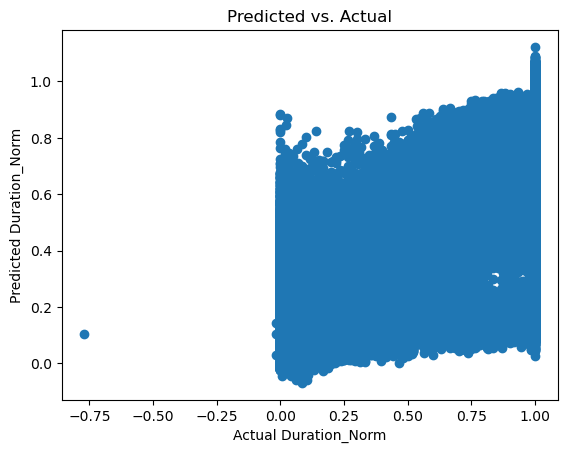

In [ ]:
# Plot predicted vs actual values
import matplotlib.pyplot as plt
plt.scatter(y_test, preds)
plt.xlabel("Actual Duration_Norm")
plt.ylabel("Predicted Duration_Norm")
plt.title("Predicted vs. Actual")
plt.show()


In [ ]:
# Feature Importance
import pandas as pd
fi = model.get_feature_importance()
names = model.feature_names_
fi_df = pd.DataFrame({'feature': names, 'importance': fi}).sort_values('importance', ascending=False)
print(fi_df.head(10))


                     feature  importance
15                    Status   48.645562
5                   New_Used    9.476191
9              Customer_Cost    8.610621
0                       Term    8.353237
10              Down_Payment    7.710635
1                Vehicle_Age    4.137810
14  Customer_Monthly_Payment    3.788199
12             Warranty_Cost    2.988320
7               Finance_Term    2.263261
11           Finance_Payment    1.315541


In [60]:
from catboost import Pool, cv
pool = Pool(X, y, cat_features=cat_features)
params = model.get_params()
cv_data = cv(pool, params, fold_count=5, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.3793653	test: 0.3782763	best: 0.3782763 (0)	total: 344ms	remaining: 2m 51s
100:	learn: 0.1634365	test: 0.1633459	best: 0.1633459 (100)	total: 29s	remaining: 1m 54s
200:	learn: 0.1598693	test: 0.1598362	best: 0.1598362 (200)	total: 1m 4s	remaining: 1m 36s
300:	learn: 0.1582116	test: 0.1582347	best: 0.1582347 (300)	total: 1m 42s	remaining: 1m 7s
400:	learn: 0.1571259	test: 0.1571960	best: 0.1571960 (400)	total: 2m 20s	remaining: 34.6s
499:	learn: 0.1564579	test: 0.1565520	best: 0.1565520 (499)	total: 2m 56s	remaining: 0us

bestTest = 0.1565519871
bestIteration = 499

Training on fold [1/5]
0:	learn: 0.3790860	test: 0.3793494	best: 0.3793494 (0)	total: 370ms	remaining: 3m 4s
100:	learn: 0.1634209	test: 0.1631978	best: 0.1631978 (100)	total: 32.1s	remaining: 2m 6s
200:	learn: 0.1599429	test: 0.1596629	best: 0.1596629 (200)	total: 1m 9s	remaining: 1m 43s
300:	learn: 0.1582976	test: 0.1580321	best: 0.1580321 (300)	total: 1m 46s	remaining: 1m 10s
400:	learn:

### Random Forest

In [69]:
df_model.head(10)

,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Duration,Duration_Norm,Status_bin
97127,60.0,11.0,44,261,62612,5,163612,36,100000.0,3129.0,189.00,81.67,1629.0,0.0,79.90,15.0,0.250000,1
97128,72.0,19.0,18,572,124000,5,200000,36,75000.0,3594.0,179.70,94.84,1694.0,0.0,94.84,3.0,0.041667,1
97129,60.0,14.0,12,1301,99691,5,175691,36,75000.0,3388.0,169.40,89.41,1088.0,0.0,89.41,60.0,1.000000,0
97130,60.0,14.0,12,290,41006,5,96006,36,54000.0,3780.0,189.00,99.75,1348.0,0.0,99.75,30.0,0.500000,1
97133,60.0,10.0,52,1189,66926,5,167926,36,100000.0,3501.0,175.05,92.39,1001.0,0.0,92.39,0.0,0.000000,1
97134,60.0,12.0,16,470,97102,5,198102,36,100000.0,3955.0,197.95,104.36,2073.0,0.0,104.36,60.0,1.000000,0
97135,60.0,14.0,33,850,92001,5,153001,36,60000.0,3517.0,175.85,92.81,1835.0,0.0,92.81,3.0,0.050000,1
97136,60.0,11.0,10,201,95646,5,146646,36,50000.0,3607.0,180.35,95.18,1207.0,0.0,95.18,11.0,0.183333,1
97138,60.0,11.0,10,201,24631,1,61000,36,60000.0,2754.0,137.70,72.68,1322.0,0.0,72.68,9.0,0.150000,1
97139,60.0,9.0,12,1301,86766,5,212766,36,125000.0,4305.0,116.35,116.35,2123.0,0.0,113.60,60.0,1.000000,0


In [70]:
# Drop unnecessary columns for modeling
X = df_model.drop(columns=['Duration', 'Duration_Norm'])

# Define the target variable
y = df_model['Duration_Norm']

In [71]:
X.head(10)

,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status_bin
97127,60.0,11.0,44,261,62612,5,163612,36,100000.0,3129.0,189.00,81.67,1629.0,0.0,79.90,1
97128,72.0,19.0,18,572,124000,5,200000,36,75000.0,3594.0,179.70,94.84,1694.0,0.0,94.84,1
97129,60.0,14.0,12,1301,99691,5,175691,36,75000.0,3388.0,169.40,89.41,1088.0,0.0,89.41,0
97130,60.0,14.0,12,290,41006,5,96006,36,54000.0,3780.0,189.00,99.75,1348.0,0.0,99.75,1
97133,60.0,10.0,52,1189,66926,5,167926,36,100000.0,3501.0,175.05,92.39,1001.0,0.0,92.39,1
97134,60.0,12.0,16,470,97102,5,198102,36,100000.0,3955.0,197.95,104.36,2073.0,0.0,104.36,0
97135,60.0,14.0,33,850,92001,5,153001,36,60000.0,3517.0,175.85,92.81,1835.0,0.0,92.81,1
97136,60.0,11.0,10,201,95646,5,146646,36,50000.0,3607.0,180.35,95.18,1207.0,0.0,95.18,1
97138,60.0,11.0,10,201,24631,1,61000,36,60000.0,2754.0,137.70,72.68,1322.0,0.0,72.68,1
97139,60.0,9.0,12,1301,86766,5,212766,36,125000.0,4305.0,116.35,116.35,2123.0,0.0,113.60,0


In [72]:
X.shape

(1304208, 16)

In [ ]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [74]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,    # try 100–500
    max_depth=10,        # tune between 5–20
    min_samples_leaf=5,  # prevents tiny leaves
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [76]:
preds = rf.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
r2   = r2_score(y_test, preds)
print(f"RF Test  RMSE: {rmse:.4f}")
print(f"RF Test    R²: {r2:.4f}")

RF Test  RMSE: 0.1528
RF Test    R²: 0.7043


In [78]:
from sklearn.model_selection import  cross_val_score

cv_rmse = -cross_val_score(
    rf, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
).mean()
print(f"RF 5-fold CV RMSE: {cv_rmse:.4f}")

RF 5-fold CV RMSE: 0.1522


In [79]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.nlargest(10))

Status_bin                  0.943911
Customer_Monthly_Payment    0.013235
Finance_Payment             0.012168
Down_Payment                0.006770
Term                        0.006101
Vehicle_Age                 0.003839
Finance_Term                0.003186
Warranty_Cost               0.002872
Customer_Cost               0.002680
Mileage                     0.002538
dtype: float64


In [80]:
X_test.head(10)

,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status_bin
1681746,60.0,21.0,70,291,162655,5,213655,36,50000.0,3607.00,180.35,95.18,1188.0,0.0,95.18,1
524684,48.0,17.0,52,1545,173065,5,234065,30,60000.0,4641.00,149.70,149.71,1650.0,0.0,149.71,1
1863691,48.0,7.0,52,932,91248,5,152248,29,60000.0,5963.00,198.77,198.77,2441.0,0.0,402.54,1
737945,84.0,1.0,18,535,2806,1,101000,30,100000.0,4863.00,156.88,156.87,1603.0,0.0,156.87,1
1502931,60.0,9.0,12,1432,60600,5,161600,36,100000.0,3938.00,196.90,103.92,2463.0,0.0,103.92,1
194462,48.0,10.0,12,1340,149702,5,198702,30,48000.0,4201.00,135.52,135.52,1801.0,0.0,135.51,1
1191967,48.0,10.0,52,1287,81062,5,157062,30,75000.0,6427.00,211.28,207.19,4102.0,0.0,414.38,1
317722,60.0,12.0,37,1207,112329,5,213329,24,100000.0,4244.03,212.20,167.99,1616.0,0.0,167.99,1
1622917,48.0,11.0,6,115,82762,5,158762,30,75000.0,6470.00,208.71,208.71,5013.0,0.0,208.70,1
238406,48.0,13.0,12,921,239000,5,315000,30,75000.0,5652.00,182.33,182.32,3427.0,0.0,182.32,1


### XGBoost


In [95]:

from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [96]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1
)


In [98]:
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:0.27864
[100]	validation_0-rmse:0.15293
[200]	validation_0-rmse:0.15174
[300]	validation_0-rmse:0.15111
[400]	validation_0-rmse:0.15080
[499]	validation_0-rmse:0.15058


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [99]:
preds = xgb.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)
print(f"\nXGBoost Test RMSE: {rmse:.4f}")
print(f" XGBoost Test R²:   {r2:.4f}")


XGBoost Test RMSE: 0.1506
 XGBoost Test R²:   0.7127
